In [1]:
!pip install pyDOE
#  !pip install all other things if it gives you errors

  Preparing metadata (setup.py) ... - done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=679d0cfafc8174c31203a9b25fdd7652d40eb0800ff03ed40907f0a4c32194a2
  Stored in directory: /root/.cache/pip/wheels/6d/33/f3/4c4a14bf9bbfda40c5355127c31ddd38bb72fa6b449c651881
Successfully built pyDOE


In [2]:
#you need to add a dataset with GaussJacobiQuadRule_V3 on the right 
import sys
sys.path.insert(1, '/kaggle/input/quadrule')
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights

#import GaussJacobiQuadRule_V3


import tensorflow 
tf=tensorflow.compat.v1
#tf.disable_v2_behavior()
import pyDOE

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pyDOE import lhs
#from GaussJacobiQuadRule_V3.py import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time

In [3]:
# %load building_VPINN_network.py


###############################################################################

# import tensorflow as tf

import tensorflow 
tf=tensorflow.compat.v1
#tf.disable_v2_behavior()
import pyDOE

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pyDOE import lhs
#from GaussJacobiQuadRule_V3.py import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time

#from tensorflow import placeholder


np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

###############################################################################

                #X_u_bound,u_bound,               points for training at the boundary -> size(N_bound_points,1)
                #X_quad_train, W_quad_train,      quadrature weights and points in (-1,1),array size -> (N_quad,1)
                #F_ext_total,                     fh calculated on each elem for each test function on the quad nodes size ->(N_Elements,N_testfcn,1)
                #grid,                            lispace grid between -1 and 1 with N_quad number of points points 
                #X_test,u_test     		    test points between -1 and 1 depends equispaced with delta_test and uex evalueted on these 
                #Net_layer         		    array of integer with number of neurons for each layer
                #X_f_train,                       random Nf points for trianing,then evalueted on f_ext
                #f_train,                         
                #params=params                    hyperparameters of the network/loss options

class VPINN:
    def __init__(self, X_u_bound, u_bound, X_quad, W_quad, F_exact_total,\
                 grid, X_test, u_test, layers, X_f_train, f_train, params):

        self.x       = X_u_bound
        self.u       = u_bound
        
        self.xf      = X_f_train
        self.f      = f_train
        
        self.xquad   = X_quad
        self.wquad   = W_quad  #weights for quadrature to calculate the loss
        
        self.xtest   = X_test
        self.utest   = u_test
        
        self.F_ext_total = F_exact_total
        self.Nelement = np.shape(self.F_ext_total)[0]  #number of elements  
        self.N_test   = np.shape(self.F_ext_total[0])[0] #number of test function
        
        self.x_tf   = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]]) #????placeholder is a variable that we will assign later on
        self.u_tf   = tf.placeholder(tf.float64, shape=[None, self.u.shape[1]])
        self.xf_tf   = tf.placeholder(tf.float64, shape=[None, self.xf.shape[1]])
        self.f_tf   = tf.placeholder(tf.float64, shape=[None, self.f.shape[1]])
        self.x_test = tf.placeholder(tf.float64, shape=[None, self.xtest.shape[1]])
        self.x_quad = tf.placeholder(tf.float64, shape=[None, self.xquad.shape[1]])
      
        self.weights, self.biases, self.a = self.initialize_NN(layers)
        
        #ingredients for discrete integrals,remark the newtork is not just one you need to calculate in poisson case u(x,y) ,d/dx u(x,y) ,d/dy u(x,y)
        
        self.u_NN_quad  = self.net_u(self.x_quad) #x_quad is a row tensor 
        
        self.d1u_NN_quad, self.d2u_NN_quad = self.net_du(self.x_quad)
         
       	self.test_quad   = self.Test_fcn(self.N_test, self.xquad)
       	
        self.d1test_quad, self.d2test_quad = self.dTest_fcn(self.N_test, self.xquad)
        
 
        
        self.u_NN_pred   = self.net_u(self.x_tf)
        self.u_NN_test   = self.net_u(self.x_test)
        self.f_pred = self.net_f(self.x_test) #evaluete f through the network ??
        
        
        #start from there -> loss calculation
        self.varloss_total = 0
        for e in range(self.Nelement):
            F_ext_element  = self.F_ext_total[e]
            Ntest_element  = np.shape(F_ext_element)[0] #for each you have N_testfcn
            
            x_quad_element = tf.constant(grid[e] + (grid[e+1]-grid[e])/2*(self.xquad+1))
            x_b_element    = tf.constant(np.array([[grid[e]], [grid[e+1]]]))
            #to change change integral to the ref segment in (-1,1)
            jacobian       = (grid[e+1]-grid[e])/2

            test_quad_element = self.Test_fcn(Ntest_element, self.xquad)
            d1test_quad_element, d2test_quad_element = self.dTest_fcn(Ntest_element, self.xquad)
            
            u_NN_quad_element = self.net_u(x_quad_element)
            d1u_NN_quad_element, d2u_NN_quad_element = self.net_du(x_quad_element)

            u_NN_bound_element = self.net_u(x_b_element)
            d1test_bound_element, d2test_bounda_element = self.dTest_fcn(Ntest_element, np.array([[-1],[1]]))

            var_form = params['var_form']

            if var_form == 1:
                U_NN_element = tf.reshape(tf.stack([-jacobian*tf.reduce_sum(self.wquad*d2u_NN_quad_element*test_quad_element[i]) \
                                                   for i in range(Ntest_element)]),(-1,1))
            if var_form == 2:
                U_NN_element = tf.reshape(tf.stack([ tf.reduce_sum(self.wquad*d1u_NN_quad_element*d1test_quad_element[i]) \
                                                    for i in range(Ntest_element)]),(-1,1))                                 #i think we are going to use this most of the times 
            if var_form == 3:
                U_NN_element = tf.reshape(tf.stack([-1/jacobian*tf.reduce_sum(self.wquad*u_NN_quad_element*d2test_quad_element[i]) \
                                                   +1/jacobian*tf.reduce_sum(u_NN_bound_element*np.array([-d1test_bound_element[i][0], d1test_bound_element[i][-1]]))  \
                                                   for i in range(Ntest_element)]),(-1,1))
                
            print(U_NN_element.shape)
            Res_NN_element = U_NN_element - F_ext_element
            loss_element = tf.reduce_mean(tf.square(Res_NN_element))
            self.varloss_total = self.varloss_total + loss_element
        
        self.lossb = tf.reduce_mean(tf.square(self.u_tf - self.u_NN_pred))  #u_NN_pred is what your network has calc,while u_tf is the real value
        self.lossv = self.varloss_total
        #two losses 
        self.loss  = params['lossb_weight']*self.lossb + self.lossv
        
        self.LR = params['LR']
        self.optimizer_Adam = tf.train.AdamOptimizer(self.LR)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        self.sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)

###############################################################################
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        #transpose everything to have the classic form y=W*x+b 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            a = tf.Variable(0.01, dtype=tf.float64)
            weights.append(W)
            biases.append(b)        
        return weights, biases, a
        
        
    def xavier_init(self, size): #marked for future develop*********************
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim), dtype=np.float64)
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev,dtype=tf.float64), dtype=tf.float64) #maybe should the init be changed
 
    def neural_net(self, X, weights, biases, a): #marked for future develop 
        num_layers = len(weights) + 1
        H = X 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b)) #change here for having different activation function
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x):  #marked for future develop
        u = self.neural_net(tf.concat([x],1), self.weights, self.biases, self.a)
        return u

    def net_du(self, x): #calculates first and second derivatives of the input unn d/dx unn d^2/dx^2 unn so it can compute loss
        u   = self.net_u(x)
        d1u = tf.gradients(u, x)[0]
        d2u = tf.gradients(d1u, x)[0]
        return d1u, d2u

    def net_f(self, x): #marked for future develop*********************
        u = self.net_u(x)
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = - u_xx
        return f
    
    #vtest functions == jacobi polynomils valueted on a point x
    def Test_fcn(self, N_test,x):
        test_total = []
        for n in range(1,N_test+1):  
            test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
            test_total.append(test)
        return np.asarray(test_total)

    def dTest_fcn(self, N_test,x):  #valuete the first and second derivatives of test functions on a point x 
        d1test_total = []
        d2test_total = []
        for n in range(1,N_test+1):  
            if n==1:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n==2:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
            else:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x) - ((n)*(n+1)/(2*2))*Jacobi(n-3,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
        return np.asarray(d1test_total), np.asarray(d2test_total)

    def predict_subdomain(self, grid):
        error_u_total = []
        u_pred_total = []
        for e in range(self.Nelement):
            utest_element = self.utest_total[e]
            x_test_element = grid[e] + (grid[e+1]-grid[e])/2*(self.xtest+1)
            u_pred_element = self.sess.run(self.u_NN_test, {self.x_test: x_test_element})
            error_u_element = np.linalg.norm(utest_element - u_pred_element,2)/np.linalg.norm(utest_element,2)
            error_u_total.append(error_u_element)
            u_pred_total.append(u_pred_element)
        return u_pred_total, error_u_total

    def predict(self, x):
        u_pred  = self.sess.run(self.u_NN_test, {self.x_test: x})
        return u_pred        

    def train(self, nIter, tresh, total_record):
        
        tf_dict = {self.x_tf: self.x, self.u_tf: self.u,\
                   self.x_quad: self.xquad, self.x_test: self.xtest,\
                   self.xf_tf: self.xf, self.f_tf: self.f}    #maybe like variables sess.run will do the rest, u(boundary cond) is assigned to u_tf ,x(boundary) is assigned to x_tf and so on
        start_time       = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            #each 10 iter saves loss values
            if it % 10 == 0:
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_valueb= self.sess.run(self.lossb, tf_dict)
                loss_valuev= self.sess.run(self.lossv, tf_dict)
                total_record.append(np.array([it, loss_value,loss_valueb,loss_valuev]))
                
                if loss_value < tresh:
                    print('It: %d, Loss: %.3e' % (it, loss_value))
                    break
                
            if it % 100 == 0:
                elapsed = time.time() - start_time
                str_print = 'It: %d, Lossb: %.3e, Lossv: %.3e, Time: %.2f'
                print(str_print % (it, loss_valueb, loss_valuev, elapsed))
                start_time = time.time()

        return total_record


In [4]:
tf.compat.v1.disable_v2_behavior()

# from tensorflow import placeholder

                    # a(u,v)=f(v) u in H1 such that is 0 on diriclet boundary for every v in V -->ah(u,vh)=fh(vh) for every vh in Vh

    
    #++++++++++++++++++++++++++++
LR = 0.001
Opt_Niter = 5000 + 1
Opt_tresh = 2e-32
var_form  = 2  #i think that makes the most sense leaving it to 2(variational form)
N_Element = 20
Net_layer = [1] + [20] * 4 + [1] # [1 20 20 20 20 1] number of neurons in each later numer of param == (input_layer+1)*output_layer in this case 2*20+3*(21*20)+21*1=1321 total param
N_testfcn = 20 #number of test function
N_Quad = 100    #quadrature points 


N_F = 500      #number of points used for trianing 
lossb_weight = 1 #hyprparameter we may turn it up

params = {'var_form': var_form, 'lossb_weight': lossb_weight, 'LR': LR}
    
#++++++++++++++++++++++++++++    valuete Test function of order n in a point x(n>=1)
def Test_fcn(n,x):
    test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
    return test

#++++++++++++++++++++++++++++    
#exact sol and forcing term
omega = 8*np.pi
amp = 1
r1 = 80
def u_ext(x):
    utemp = 0.1*np.sin(omega*x) + np.tanh(r1*x)
    return amp*utemp

def f_ext(x):
    gtemp =  -0.1*(omega**2)*np.sin(omega*x) - (2*r1**2)*(np.tanh(r1*x))/((np.cosh(r1*x))**2)
    return -amp*gtemp

#++++++++++++++++++++++++++++ generate once for all quad nodes and weights in the interval [-1,1]

[x_quad, w_quad] = GaussLobattoJacobiWeights(N_Quad, 0, 0)
testfcn = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn+1)])
#testfuction is an array of evaluation of the test function on the quad nodes (size=(N_testfcn,N_quad)) in the standard interval


#generate grid elements,for each element the number of test fuction is the same  
[x_l, x_r] = [-1, 1]     #modify in the future if you want general (a,b) interval
delta_x = (x_r - x_l)/N_Element
grid = np.asarray([ x_l + i*delta_x for i in range(N_Element+1)])

N_testfcn_total = np.array((N_Element)*[N_testfcn])  #to modify in the future if we want different quadrature number for each elem ->array of size N_elem

#useless if 
if N_Element == 3:
    grid = np.array([-1, -0.1, 0.1, 1])
    NE = len(grid)-1
    N_testfcn_total = np.array([N_testfcn,N_testfcn,N_testfcn])
    
    
    

U_ext_total = []
F_ext_total = []

for e in range(N_Element):
    x_quad_element = grid[e] + (grid[e+1]-grid[e])/2*(x_quad+1)  #traslation of the element 
    
    jacobian = (grid[e+1]-grid[e])/2
    N_testfcn_temp = N_testfcn_total[e]
    testfcn_element = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn_temp+1)])
    
    #is this my left side ot the variational form ah calculated in the real nodal values ?  
    
    
    u_quad_element = u_ext(x_quad_element) #calculate u_ext on quad points of my element
    
    
    
    U_ext_element  = jacobian*np.asarray([sum(w_quad*u_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
    
    
    U_ext_element = U_ext_element[:,None]
    
    
    U_ext_total.append(U_ext_element)
    #this is fh calculated on the real nodal values summed over each real nodal values(which comes form CGL nodes )
    f_quad_element = f_ext(x_quad_element)
    F_ext_element  = jacobian*np.asarray([sum(w_quad*f_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
    
    
    F_ext_element = F_ext_element[:,None] 
    #F_ext_element now has size (N_testfcn,1)
    F_ext_total.append(F_ext_element)

U_ext_total = np.asarray(U_ext_total)
F_ext_total = np.asarray(F_ext_total) #the shape is (N_Elements,N_testfcn,1)
print(F_ext_total.shape)
# Training points

X_bound = np.asarray([-1.0,1.0])[:,None]

X_u_train = np.asarray([-1.0,1.0])[:,None]    #########


u_bound   = u_ext(X_bound)

X_f_train = (2*lhs(1,N_F)-1) #generate random number of training points between -1 and 1
f_train   = f_ext(X_f_train) #evaluete these points on f(forcing therm)


# Quadrature points
[x_quad, w_quad] = GaussLobattoJacobiWeights(N_Quad, 0, 0)

X_quad_train = x_quad[:,None] #[[w1],[w2]] none stands for new axis
W_quad_train = w_quad[:,None] #size for both (N_quad,1)

# Test point
delta_test = 0.001
xtest      = np.arange(-1 , 1 + delta_test , delta_test)  #linspace
data_temp  = np.asarray([ [xtest[i],u_ext(xtest[i])] for i in range(len(xtest))]) # pair input real ouput 
X_test = data_temp.flatten()[0::2]
u_test = data_temp.flatten()[1::2]
#test values 
X_test = X_test[:,None] 
u_test = u_test[:,None] 
f_test = f_ext(X_test)

print(X_test.shape)
print(u_test.shape)


u_test_total = []
#Test points for each elem
for e in range(N_Element):
    x_test_element = grid[e] + (grid[e+1]-grid[e])/2*(xtest+1)
    u_test_element = u_ext(x_test_element)
    u_test_element = u_test_element[:,None]
    u_test_total.append(u_test_element)
    
    
model = VPINN(X_bound, u_bound, X_quad_train, W_quad_train, F_ext_total,\
                grid, X_test, u_test, Net_layer, X_f_train, f_train, params=params)
                #X_u_bound,u_bound,               points for training at the boundary -> size(N_bound_points,1)
                #X_quad_train, W_quad_train,      quadrature weights and points in (-1,1),array size -> (N_quad,1)
                #F_ext_total,                     fh calculated on each elem for each test function on the quad nodes size ->(N_Elements,N_testfcn,1)
                #grid,                            lispace grid between -1 and 1 with N_quad number of points points 
                #X_test,u_test     		    test points between -1 and 1 depends equispaced with delta_test and uex evalueted on these 
                #Net_layer         		    array of integer with number of neurons for each layer
                #X_f_train,                       random Nf points for trianing,then evalueted on f_ext
                #f_train,                         
                #params=params                    hyperparameters of the network/loss options 

total_record = model.train(Opt_Niter, Opt_tresh, [])
u_pred = model.predict(X_test)
    


/opt/conda/lib/python3.7/site-packages/scipy/special/orthogonal.py:139: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))


(20, 20, 1)
(2001, 1)
(2001, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
It: 0, Lossb: 8.724e-01, Lossv: 8.347e+02, Time: 6.89
It: 100, Lossb: 5.548e-05, Lossv: 8.344e+02, Time: 1.13
It: 200, Lossb: 4.299e-03, Lossv: 3.353e+02, Time: 1.15
It: 300, Lossb: 2.486e-02, Lossv: 5.631e+01, Time: 1.19
It: 400, Lossb: 3.017e-02, Lossv: 2.412e+01, Time: 1.20
It: 500, Lossb: 1.160e-02, Lossv: 1.030e+01, Time: 1.17
It: 600, Lossb: 3.889e-03, Lossv: 4.414e+00, Time: 1.20
It: 700, Lossb: 1.250e-02, Lossv: 2.127e+00, Time: 1.22
It: 800, Lossb: 4.957e-03, Lossv: 1.434e+00, Time: 1.22
It: 900, Lossb: 1.508e-03, Lossv: 1.056e+00, Time: 1.21
It: 1000, Lossb: 7.199e-04, Lossv: 8.849e-01, Time: 1.23
It: 1100, Lossb: 5.429e-04, Lossv: 6.612e-01, Time: 1.20
It: 1200, Lossb: 4.845e-04, Lossv: 5.481e-01, Time: 1.24
It: 1300, Lossb: 4.149e-04, Lossv: 4.622e-01, Time: 1.21
It: 1400, Lossb: 3.156

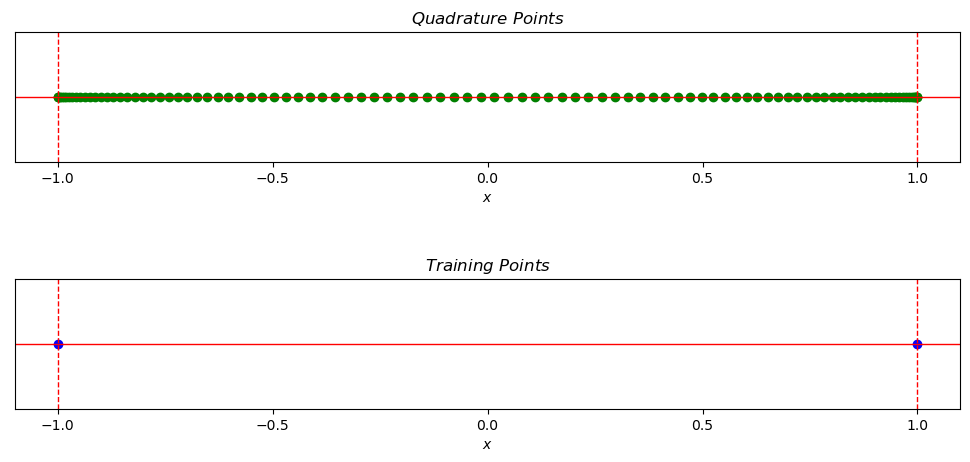

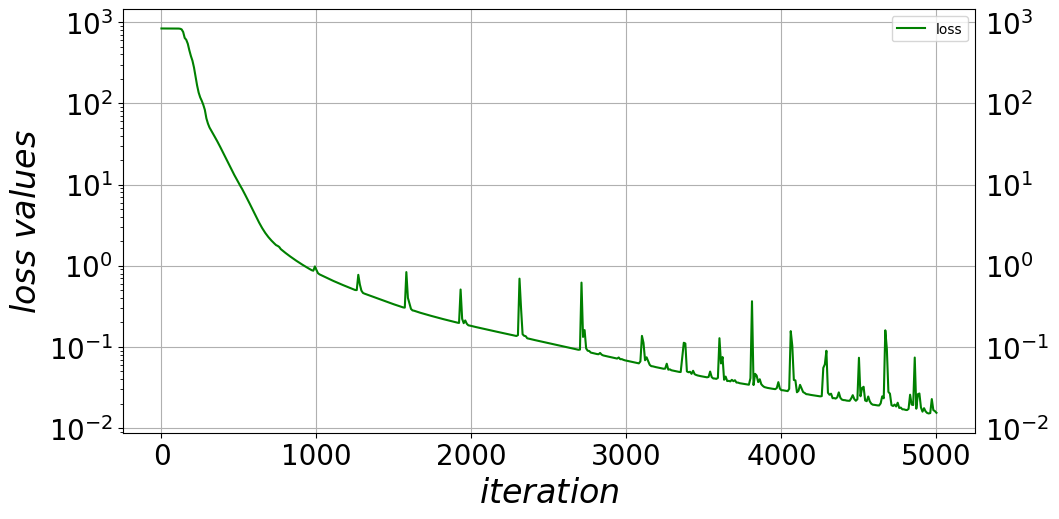

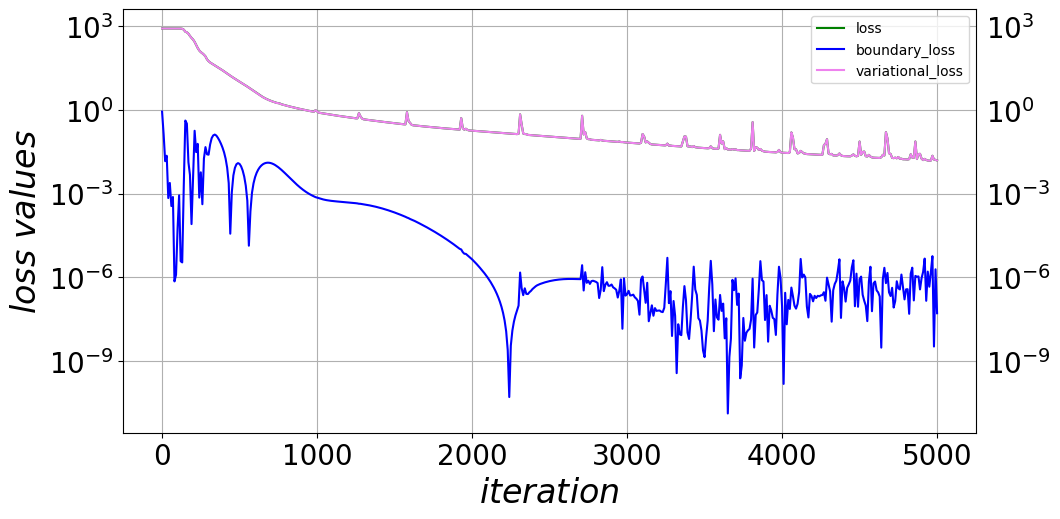

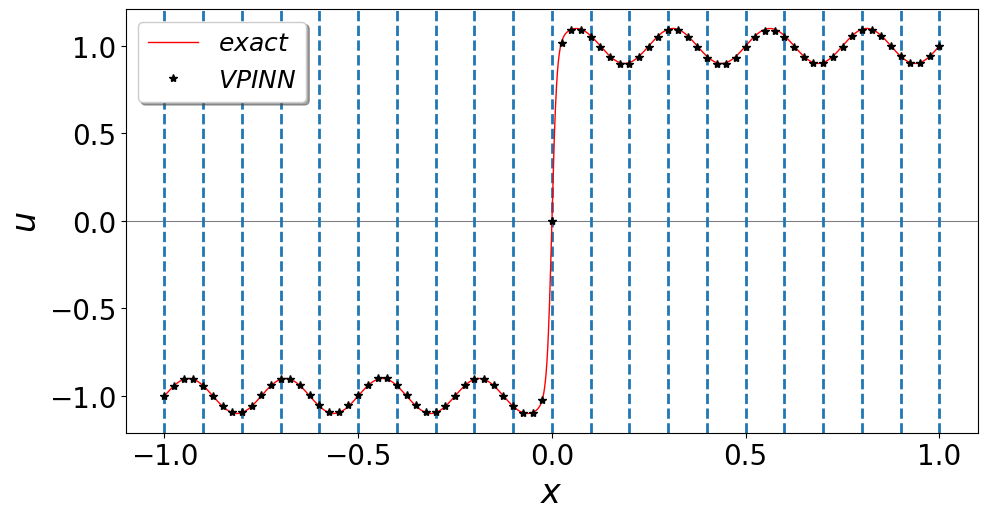

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


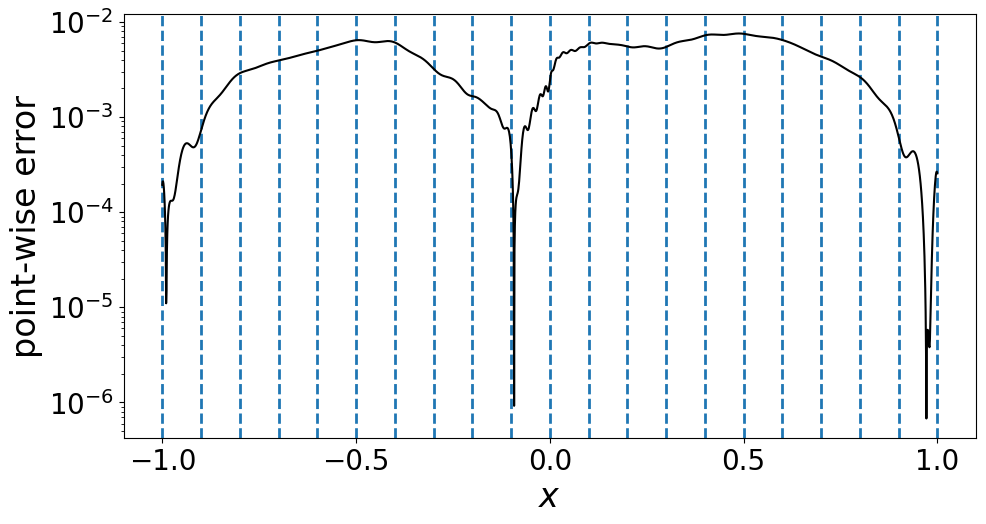

In [5]:
u_pred = model.predict(X_test)
    
    
    
    
    
    #dont care for the moment
    # =========================================================================
    #     Plotting
    # =========================================================================    
x_quad_plot = X_quad_train
y_quad_plot = np.empty(len(x_quad_plot))
y_quad_plot.fill(1)

x_train_plot = X_u_train
y_train_plot = np.empty(len(x_train_plot))
y_train_plot.fill(1) 

x_f_plot = X_f_train
y_f_plot = np.empty(len(x_f_plot))
y_f_plot.fill(1)







fig = plt.figure(0)
gridspec.GridSpec(3,1)

plt.subplot2grid((3,1), (0,0))
plt.tight_layout()
plt.locator_params(axis='x', nbins=6)
plt.yticks([])
plt.title('$Quadrature \,\, Points$')
plt.xlabel('$x$')
plt.axhline(1, linewidth=1, linestyle='-', color='red')
plt.axvline(-1, linewidth=1, linestyle='--', color='red')
plt.axvline(1, linewidth=1, linestyle='--', color='red')
plt.scatter(x_quad_plot,y_quad_plot, color='green')

plt.subplot2grid((3,1), (1,0))
plt.tight_layout()
plt.locator_params(axis='x', nbins=6)
plt.yticks([])
plt.title('$Training \,\, Points$')
plt.xlabel('$x$')
plt.axhline(1, linewidth=1, linestyle='-', color='red')
plt.axvline(-1, linewidth=1, linestyle='--', color='red')
plt.axvline(1, linewidth=1, linestyle='--', color='red')
#the data points are only the boundary points!!!!
plt.scatter(x_train_plot,y_train_plot, color='blue')

fig.tight_layout()
fig.set_size_inches(w=10,h=7)
plt.show()
# plt.savefig('Train-Quad-pnts.pdf')    
#++++++++++++++++++++++++++++

font = 24
#all loss
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off') 
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [total_record[i][0] for i in range(len(total_record))]
loss_his  = [total_record[i][1] for i in range(len(total_record))]
plt.plot(iteration, loss_his,'green',label="loss")
plt.legend(loc="upper right")
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()
# plt.savefig('loss.pdf')
#++++++++++++++++++++++++++++
#partial loss
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [total_record[i][0] for i in range(len(total_record))]
loss_his  = [total_record[i][1] for i in range(len(total_record))]
loss_b  = [total_record[i][2] for i in range(len(total_record))]
loss_v  = [total_record[i][3] for i in range(len(total_record))]
plt.plot(iteration, loss_his,'green',label="loss")
plt.plot(iteration, loss_b,'blue',label="boundary_loss")
plt.plot(iteration, loss_v, 'violet',label="variational_loss")
plt.legend(loc="upper right")
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()


pnt_skip = 25
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=8)
plt.xlabel('$x$', fontsize = font)
plt.ylabel('$u$', fontsize = font)
plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
for xc in grid:
    plt.axvline(x=xc, linewidth=2, ls = '--')
plt.plot(X_test, u_test, linewidth=1, color='r', label=''.join(['$exact$']))
plt.plot(X_test[0::pnt_skip], u_pred[0::pnt_skip], 'k*', label='$VPINN$')
plt.tick_params( labelsize = 20)
legend = plt.legend(shadow=True, loc='upper left', fontsize=18, ncol = 1)
fig.set_size_inches(w=11,h=5.5)
plt.show()
# plt.savefig('prediction.pdf')
#++++++++++++++++++++++++++++

fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=8)
plt.xlabel('$x$', fontsize = font)
plt.ylabel('point-wise error', fontsize = font)
plt.yscale('log')
plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
for xc in grid:
    plt.axvline(x=xc, linewidth=2, ls = '--')
plt.plot(X_test, abs(u_test - u_pred), 'k')
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()

#it may take a while to little bit to start